# Evaluate no-show percentages during pilot

This notebook is used for evaluating the no-show pilot by looking at the no-show percentage

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from IPython.display import display
from ipywidgets import interact
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

from noshow.features.feature_pipeline import create_features, select_feature_columns
from noshow.model.predict import create_prediction
from noshow.preprocessing.load_data import (
    load_appointment_csv,
    process_appointments,
    process_postal_codes,
)

In [2]:
load_dotenv("../.env")


# Global and env variables
db_user = os.environ["DB_USER"]
db_passwd = os.environ["DB_PASSWD"]
db_host = os.environ["DB_HOST"]
db_port = os.environ["DB_PORT"]
db_database = os.environ["DB_DATABASE"]

In [3]:
appointments_df = load_appointment_csv("../data/raw/poliafspraken_pilot.csv")
appointments_df = process_appointments(appointments_df).sort_index()
appointments_df["pilot"] = "Geen pilot"
appointments_df.loc[(slice(None), slice("2023-10-05", "2023-11-01")), "pilot"] = "pilot"
appointments_df.shape

(357617, 19)

In [4]:
CONNECTSTRING = (
    rf"mssql+pymssql://{db_user}:{db_passwd}@{db_host}:{db_port}/{db_database}"
)
engine = create_engine(CONNECTSTRING)
session_object = sessionmaker(bind=engine)

In [5]:
call_response = pd.read_sql_table("apicallresponse", engine, schema="noshow")
prediction = pd.read_sql_table("apiprediction", engine, schema="noshow")

prediction_response = prediction.merge(
    call_response, left_on="id", right_on="prediction_id", how="inner"
)
prediction_response

,id_x,prediction,start_time,clinic_name,clinic_reception,clinic_phone_number,request_id,patient_id,active,treatment,id_y,call_status,call_outcome,remarks,prediction_id
0,2030426944,0.179047,2024-03-29 08:55:00,Kind-Plastische chirurgie,"polikliniek plastische chirurgie, receptie 8",53594,2,6AE440FB530A4A19B8B36801865829018F7751436E7DF7...,False,NaN,10,Gebeld,Bel me niet,,2030426944
1,2030426997,0.270659,2024-03-29 10:35:00,Kind-Plastische chirurgie,"polikliniek plastische chirurgie, receptie 8",53594,2,26E6B241B9D18D394E843E6C9AEA8C9F135F34E3BB93A8...,False,NaN,9,Gebeld,Bel me niet,,2030426997
2,2030497678,0.032295,2024-03-15 10:30:00,Revalidatie & Sport,polikliniek revalidatie,58831,1,45BFBC37936A0A0304BA8EA4D75D72D380925319E54DAD...,False,NaN,7,Gebeld,Herinnerd,,2030497678
3,2030500929,0.071742,2024-03-13 11:30:00,Revalidatie & Sport,polikliniek revalidatie,58831,1,00805ADB677A98BBFF534A5F53D419190E13EA3F268F77...,False,NaN,1,Gebeld,Geen,,2030500929
4,2030510522,0.456338,2024-03-14 09:30:00,Revalidatie & Sport,polikliniek revalidatie,58831,1,4CE4D54795B326564F4A20E6B05574FE93B44D76022BC6...,False,NaN,2,Gebeld,Verzet/Geannuleerd,,2030510522
5,2030510667,0.138373,2024-03-14 09:30:00,Revalidatie & Sport,polikliniek revalidatie,58831,1,60C77A885AF5F17D88D1BF2B72C68E23A29C97FC8F6497...,False,NaN,6,Wordt gebeld,Geen,,2030510667
6,2030510720,0.053057,2024-03-14 09:30:00,Revalidatie & Sport,polikliniek revalidatie,58831,1,45BFBC37936A0A0304BA8EA4D75D72D380925319E54DAD...,False,NaN,8,Niet gebeld,Herinnerd,,2030510720
7,2030510795,0.188708,2024-03-14 09:30:00,Revalidatie & Sport,polikliniek revalidatie,58831,1,FE6830019D89104256F7AC1D2C32E5B3885ECEAF93B696...,False,NaN,3,Gebeld,Geen,,2030510795
8,2030569674,0.116991,2024-03-15 13:30:00,Revalidatie & Sport,polikliniek revalidatie,58831,1,FE6830019D89104256F7AC1D2C32E5B3885ECEAF93B696...,False,NaN,4,Gebeld,Geen,,2030569674
9,2030692100,0.060089,2024-05-24 14:45:00,Longziekten,"polikliniek longziekten, receptie 24a",56192,13,E18EE553973B66653D14710D9BFA4B1D637716EFA30B28...,True,NaN,12,Niet gebeld,Geen,,2030692100


## No show per month

<Axes: xlabel='month'>

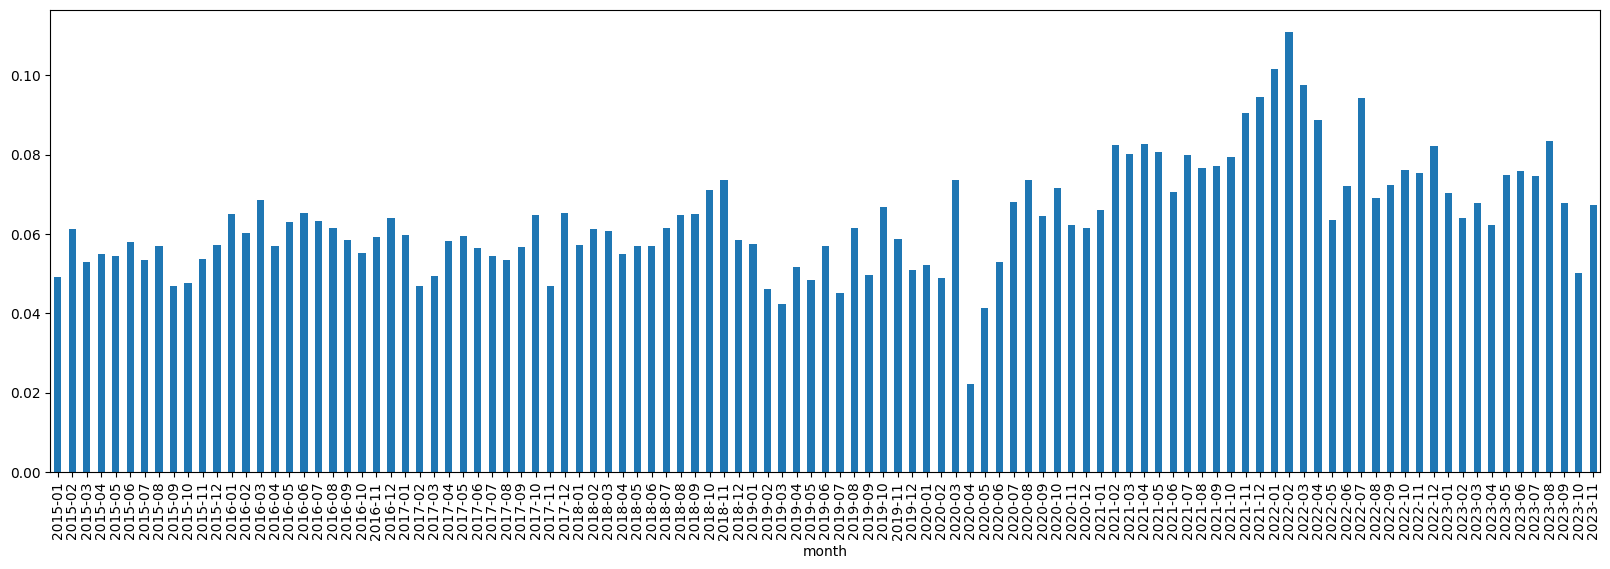

In [6]:
appointments_df["month"] = appointments_df.index.get_level_values("start").to_period(
    "M"
)
appointments_df.groupby("month")["no_show"].value_counts(True).unstack()[
    "no_show"
].plot.bar(figsize=(20, 6))

### Per clinic

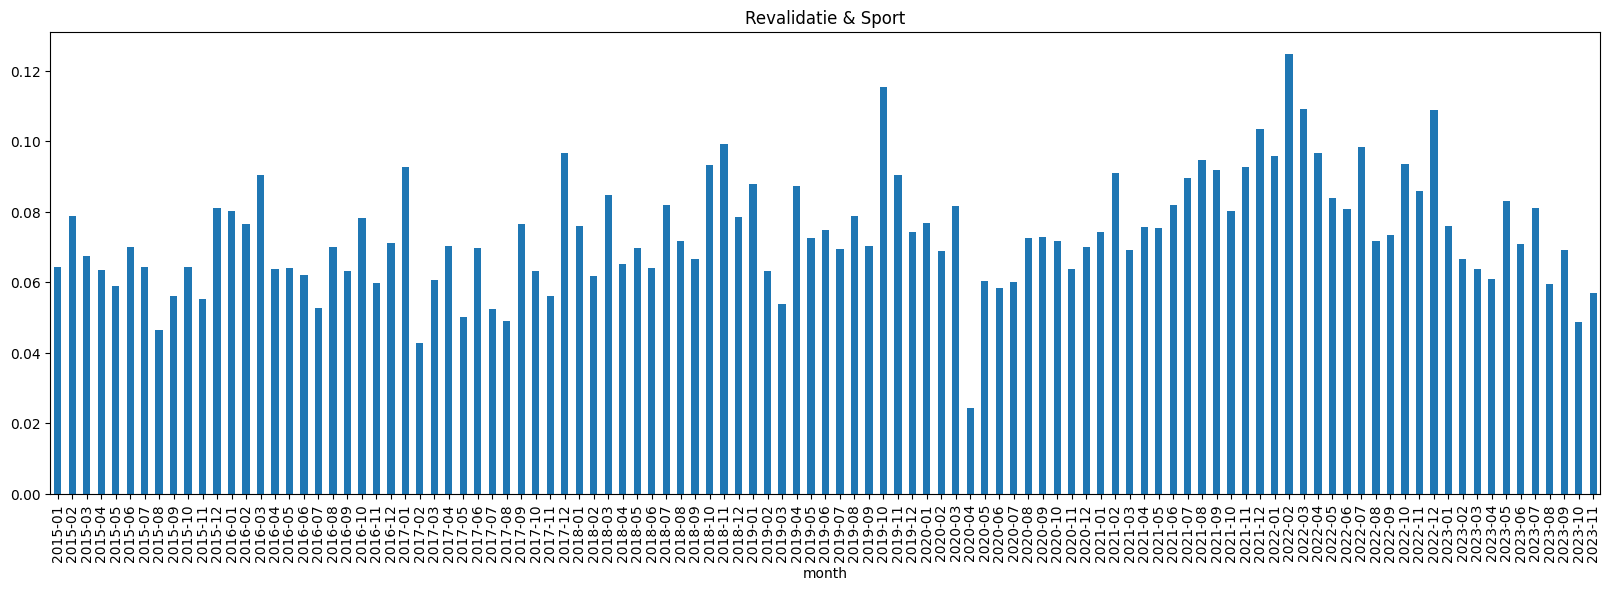

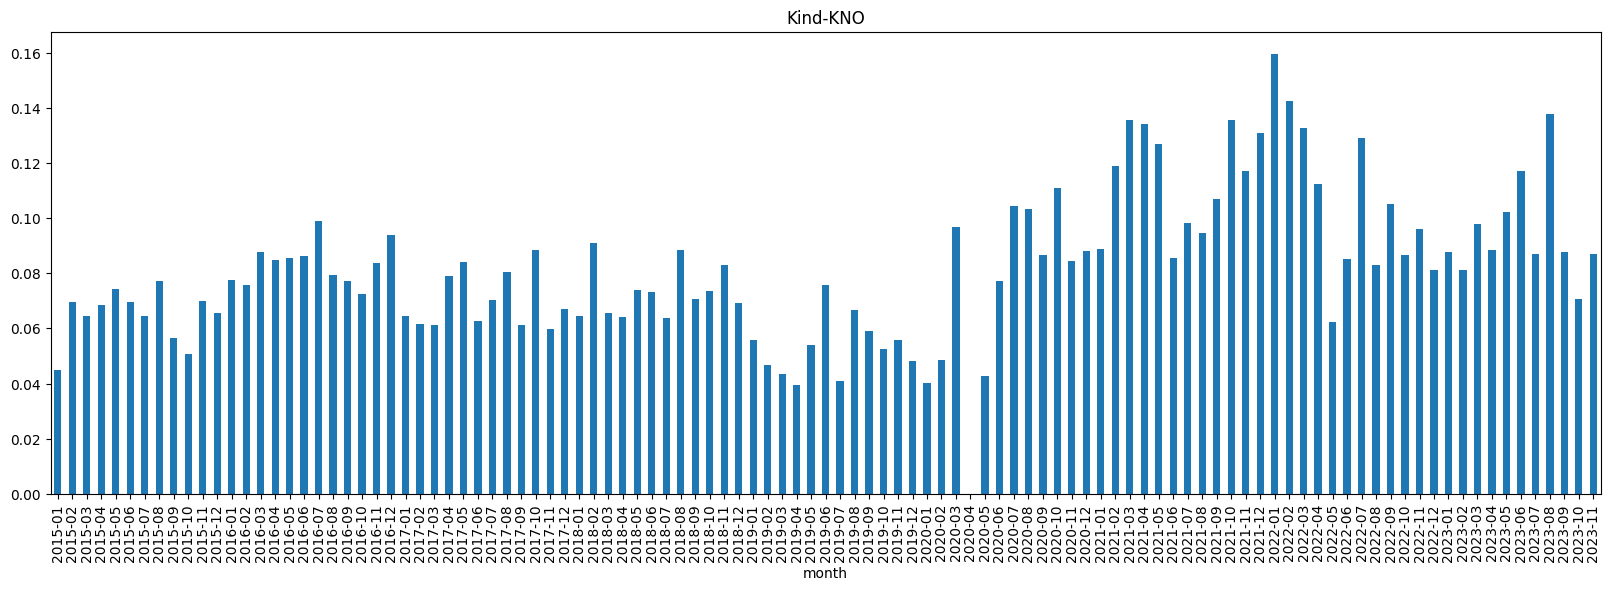

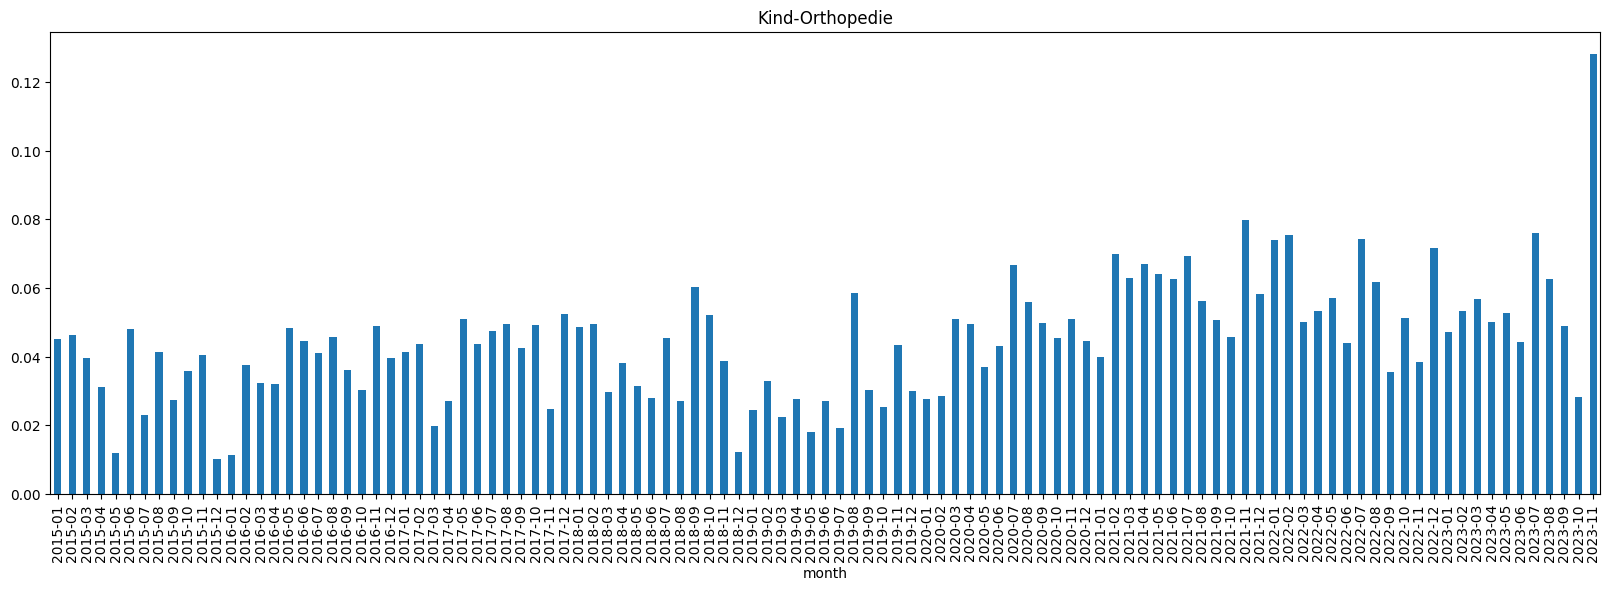

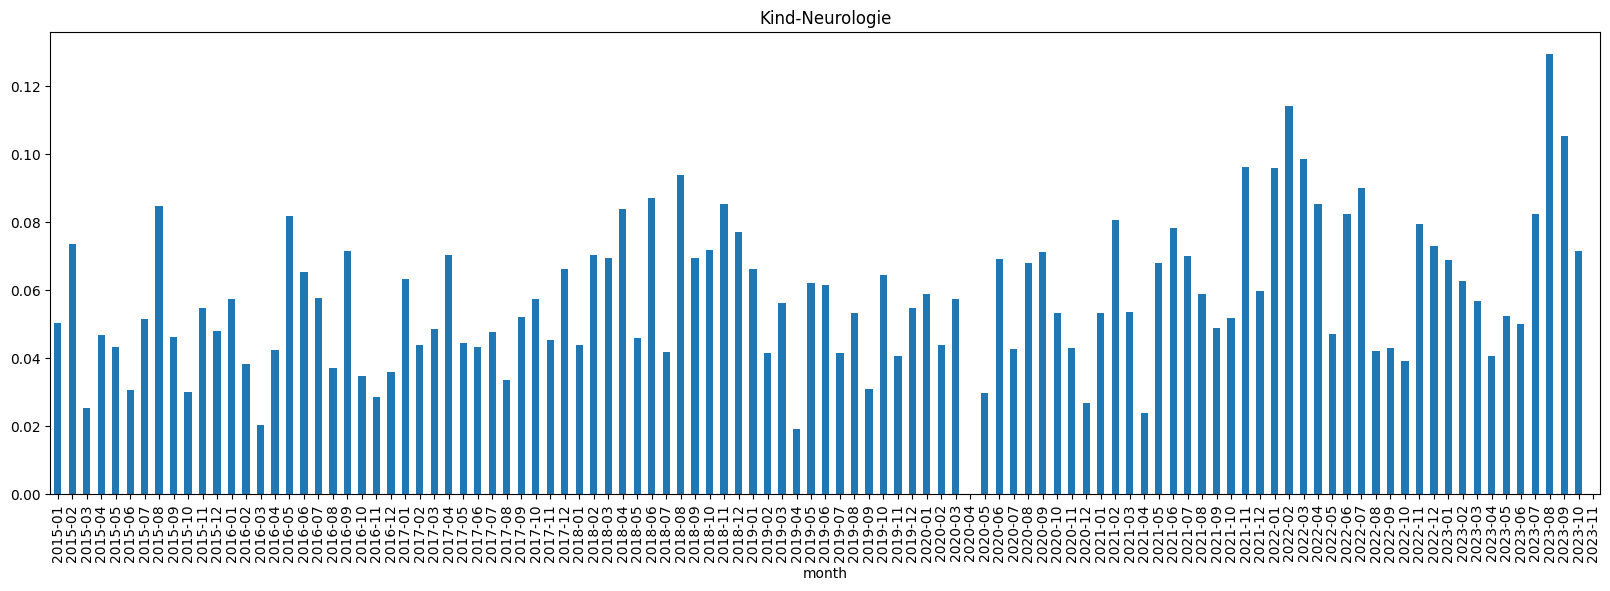

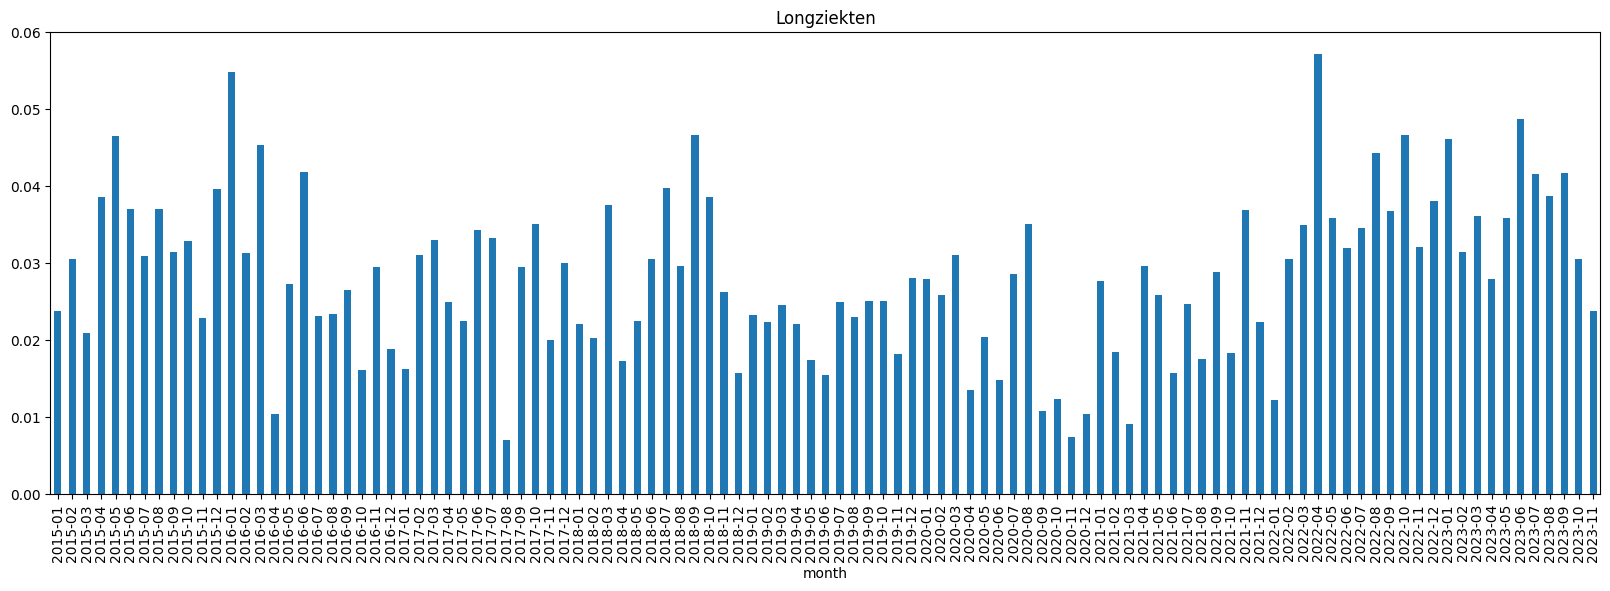

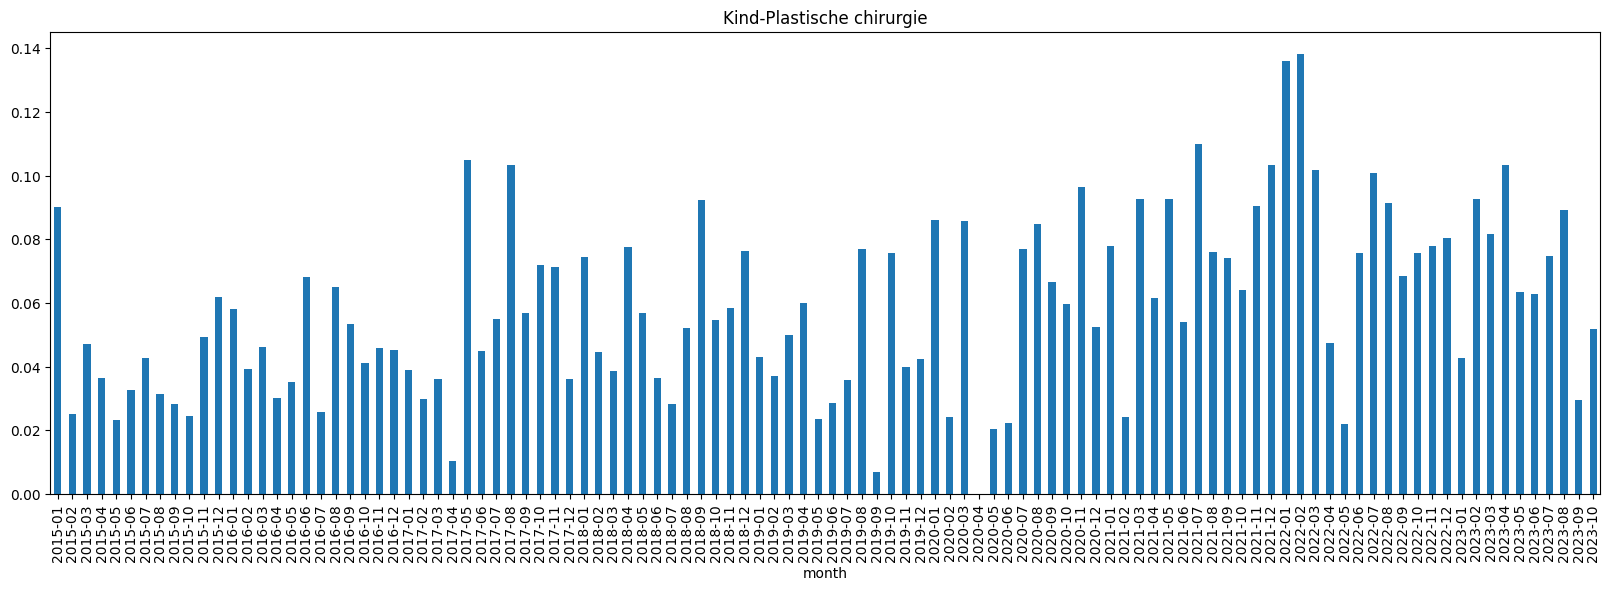

In [7]:
for agenda in appointments_df["hoofdagenda"].unique():
    (
        appointments_df.loc[appointments_df["hoofdagenda"] == agenda]
        .groupby("month")["no_show"]
        .value_counts(True)
        .unstack()["no_show"]
        .plot.bar(figsize=(20, 6), title=agenda)
    )
    plt.show()

## No show aggregated on month

pilot  Geen pilot     pilot
month                      
1        0.064735       NaN
2        0.064669       NaN
3        0.066134       NaN
4        0.063165       NaN
5        0.061569       NaN
6        0.063452       NaN
7        0.066075       NaN
8        0.067073       NaN
9        0.062275       NaN
10       0.067682  0.044767
11       0.065767       NaN
12       0.067536       NaN


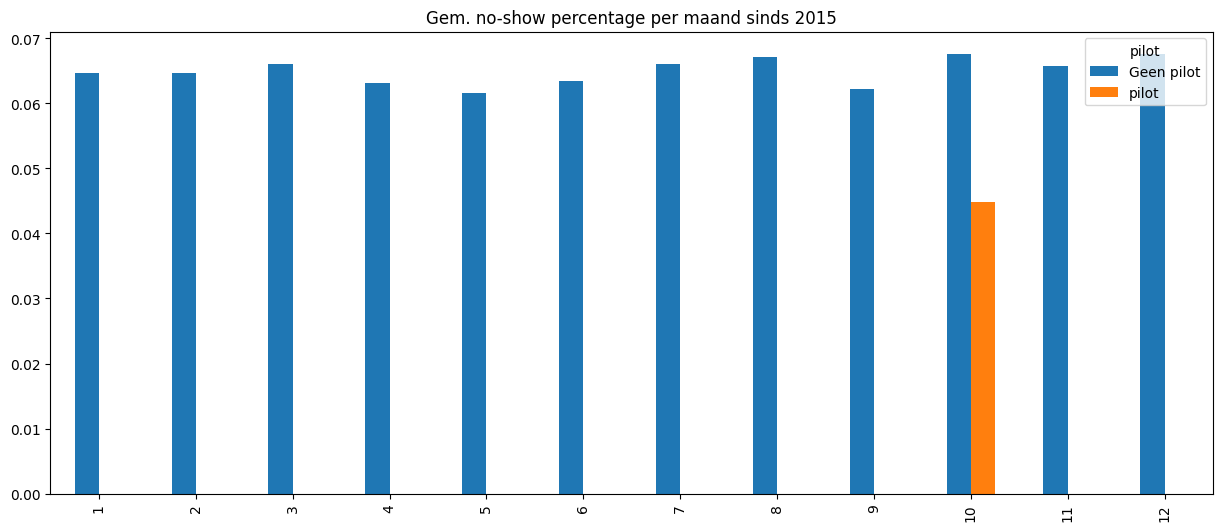

In [21]:
appointments_df["month"] = appointments_df.index.get_level_values("start").month
tmp_df = (
    appointments_df.groupby(["month", "pilot"])["no_show"]
    .value_counts(True)
    .unstack(["no_show", "pilot"])["no_show"]
)
tmp_df.loc[11, "pilot"] = None
print(tmp_df)
tmp_df.plot.bar(figsize=(15, 6))
plt.xlabel("")
plt.title("Gem. no-show percentage per maand sinds 2015")
plt.show()

### Per clinic

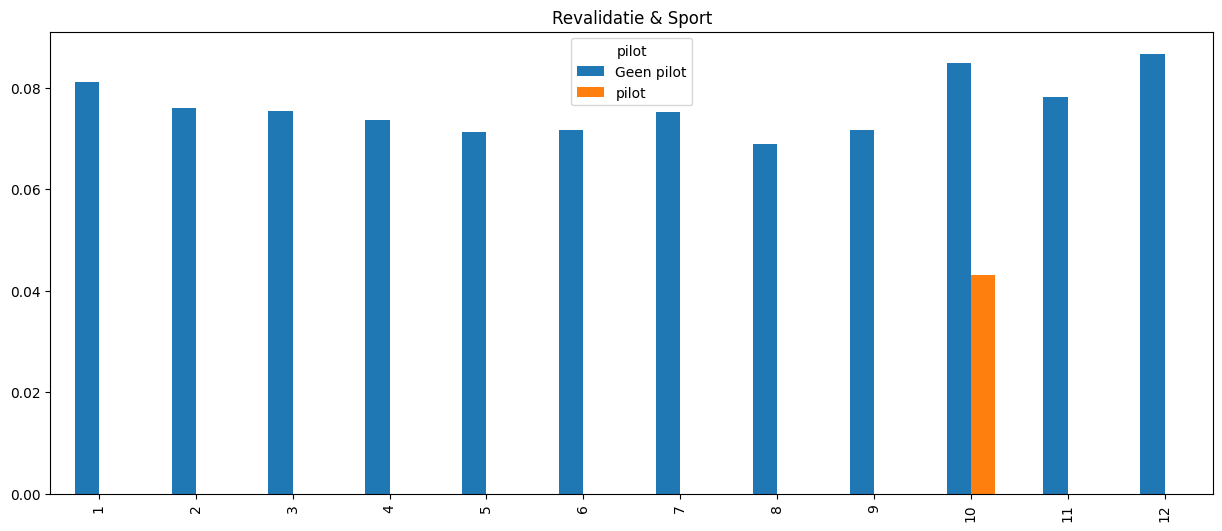

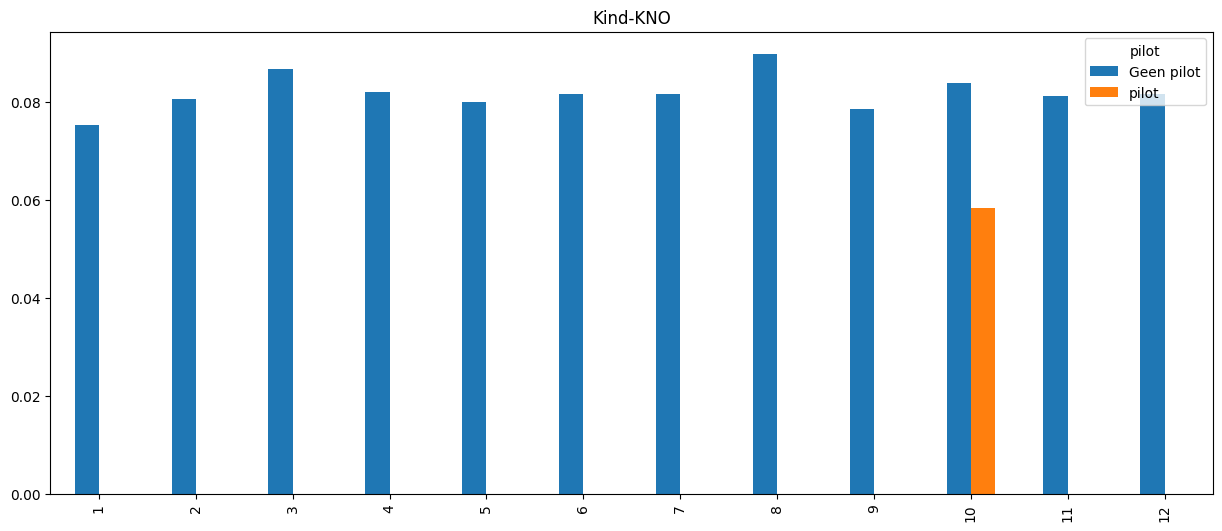

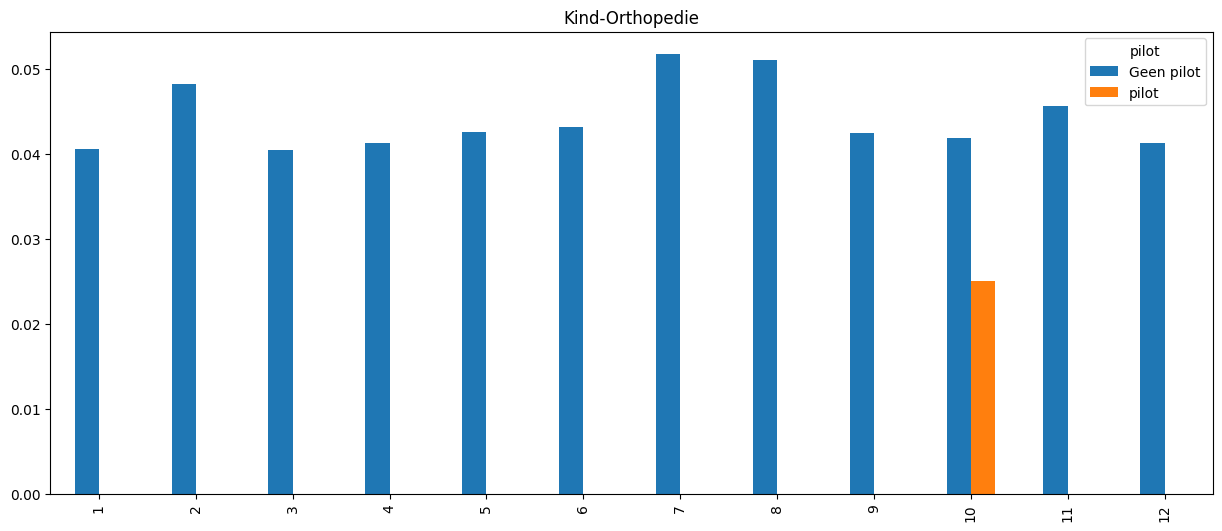

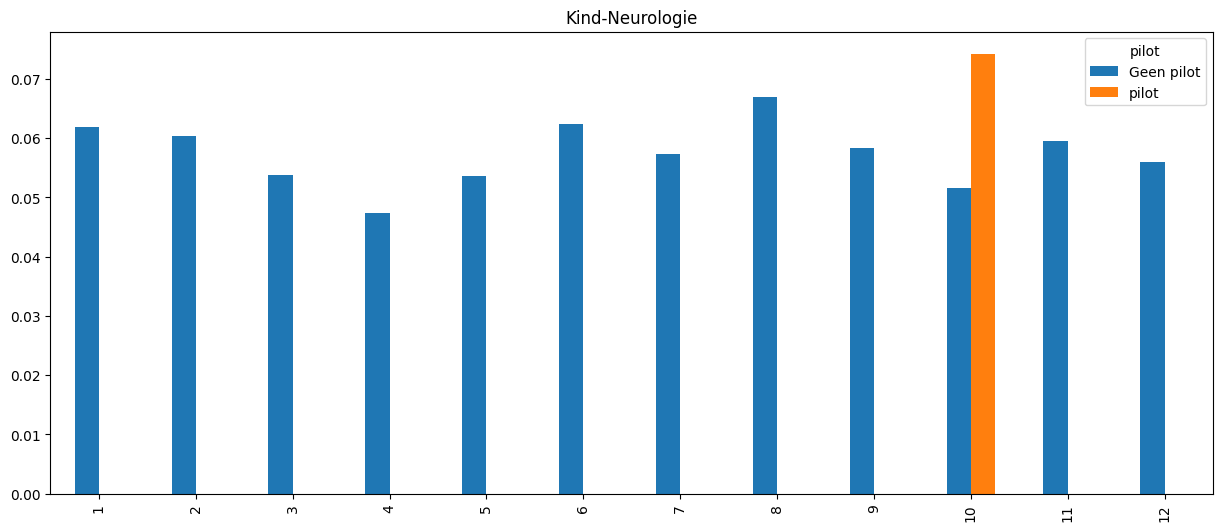

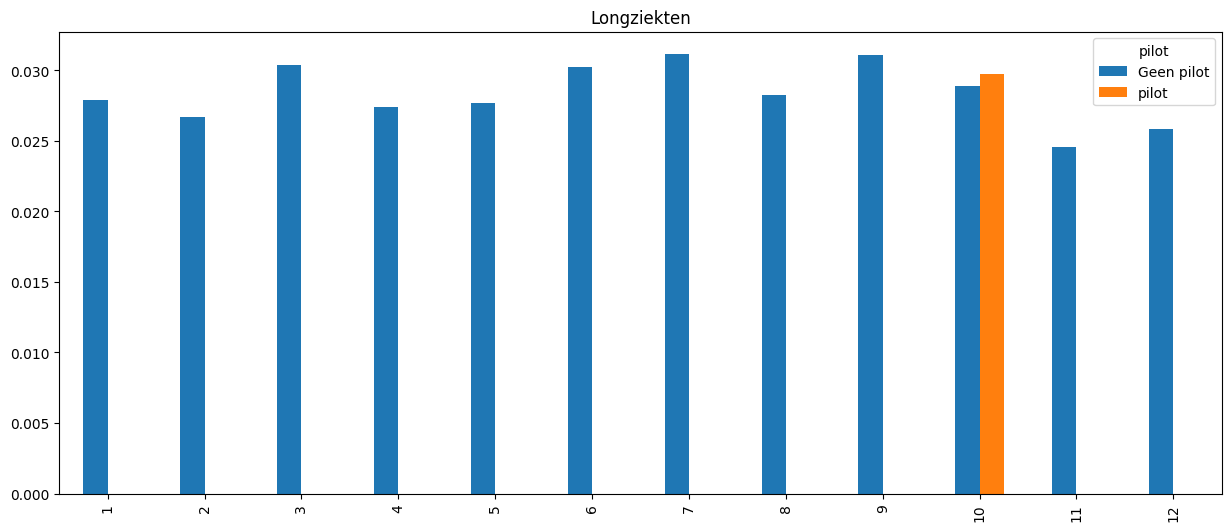

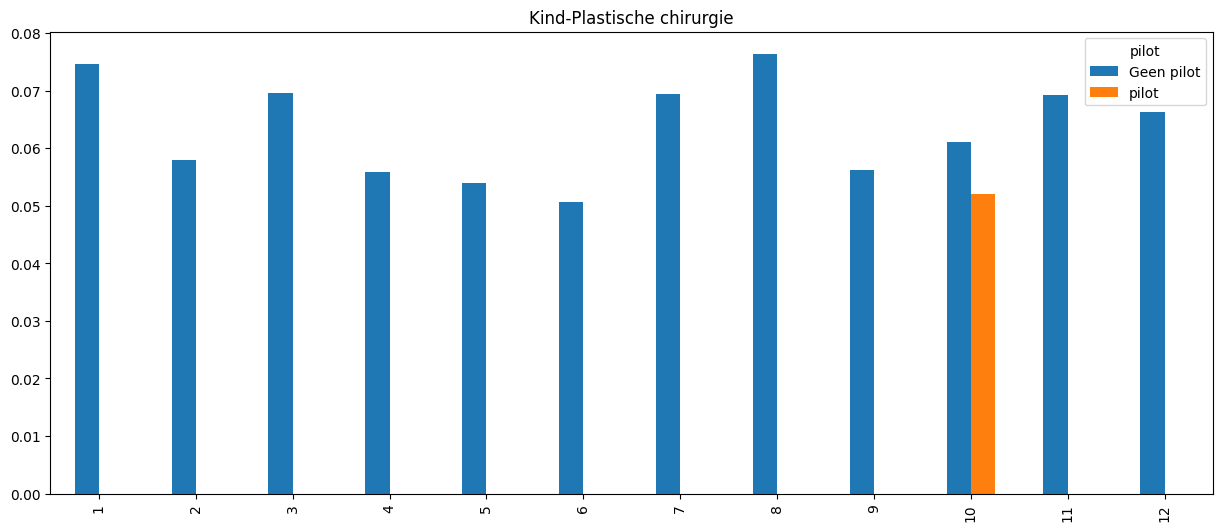

In [9]:
for agenda in appointments_df["hoofdagenda"].unique():
    tmp_df = (
        appointments_df.loc[appointments_df["hoofdagenda"] == agenda]
        .groupby(["month", "pilot"])["no_show"]
        .value_counts(True)
        .unstack(["no_show", "pilot"])["no_show"]
    )
    tmp_df.loc[11, "pilot"] = None
    tmp_df.plot.bar(figsize=(15, 6))
    plt.xlabel("")
    plt.title(agenda)
    plt.show()

## No-show percentage per prediction bin

In [10]:
with open("../output/models/no_show_model_cv.pickle", "rb") as f:
    model = pickle.load(f)

all_postalcodes = process_postal_codes("../data/raw/NL.txt")
predictions_df = create_prediction(model, appointments_df, all_postalcodes)

In [11]:
# Control group is Oct 2015 - 2022
predictions_df = predictions_df.loc[
    predictions_df.index.get_level_values("start").month == 10
]

In [12]:
total_appointments = appointments_df.join(predictions_df, how="inner")
total_appointments["predict_bin"] = pd.qcut(total_appointments["prediction"], 12)

/tmp/ipykernel_114667/1007150441.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_appointments.groupby(["pilot", "predict_bin"])["no_show"].value_counts(


<Axes: xlabel='predict_bin'>

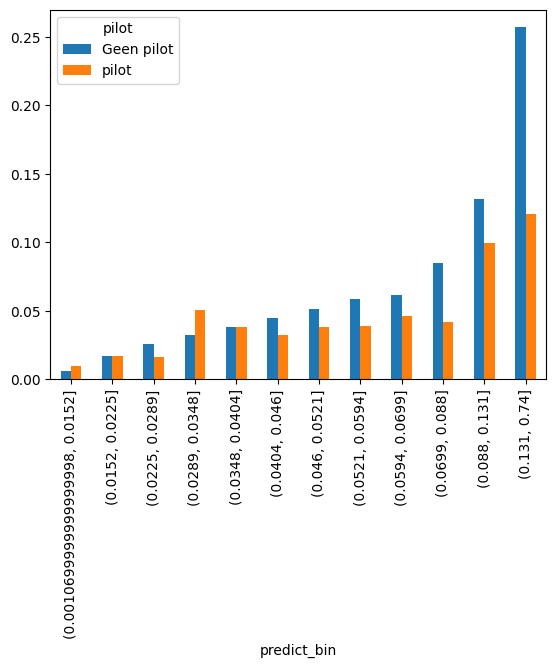

In [13]:
total_appointments.groupby(["pilot", "predict_bin"])["no_show"].value_counts(
    True
).unstack(["no_show", "pilot"])["no_show"].plot.bar()

In [14]:
total_appointments["noshow_num"] = 0
total_appointments.loc[total_appointments["no_show"] == "no_show", "noshow_num"] = 1
total_appointments_plot = total_appointments.groupby(["pilot", "predict_bin"])[
    "noshow_num"
].agg(["mean", "std", "size"])
total_appointments_plot

/tmp/ipykernel_114667/1863393336.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_appointments_plot = total_appointments.groupby(["pilot", "predict_bin"])[


mean       std  size
pilot      predict_bin                                              
Geen pilot (0.0010699999999999998, 0.0152]  0.006250  0.078826  2400
           (0.0152, 0.0225]                 0.016956  0.129134  2418
           (0.0225, 0.0289]                 0.025332  0.157165  2408
           (0.0289, 0.0348]                 0.031919  0.175820  2475
           (0.0348, 0.0404]                 0.038446  0.192309  2419
           (0.0404, 0.046]                  0.044782  0.206868  2434
           (0.046, 0.0521]                  0.051378  0.220815  2394
           (0.0521, 0.0594]                 0.058484  0.234705  2428
           (0.0594, 0.0699]                 0.061224  0.239791  2450
           (0.0699, 0.088]                  0.084951  0.278866  2472
           (0.088, 0.131]                   0.131837  0.338382  2450
           (0.131, 0.74]                    0.256919  0.437024  2421
pilot      (0.0010699999999999998, 0.0152]  0.009646  0.097898   311
           (0.0152, 0.0225]                 0.017007  0.129517   294
           (0.0225, 0.0289]                 0.016502  0.127605   303
           (0.0289, 0.0348]                 0.050847  0.220153   236
           (0.0348, 0.0404]                 0.037801  0.191042   291
           (0.0404, 0.046]                  0.032374  0.177311   278
           (0.046, 0.0521]                  0.037975  0.191438   316
           (0.0521, 0.0594]                 0.038869  0.193626   283
           (0.0594, 0.0699]                 0.045802  0.209455   262
           (0.0699, 0.088]                  0.042017  0.201050   238
           (0.088, 0.131]                   0.099617  0.300064   261
           (0.131, 0.74]                    0.120275  0.325843   291

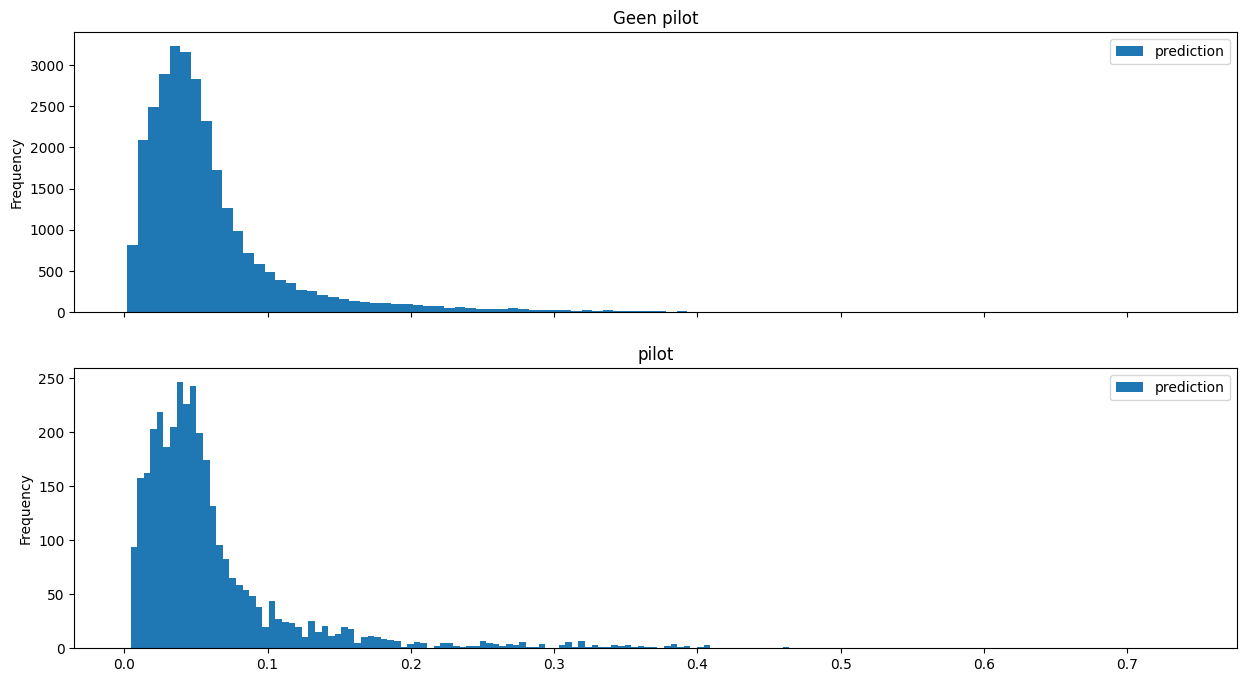

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
total_appointments[["prediction", "pilot"]].plot.hist(by="pilot", bins=100, ax=ax)
fig.show()

In [16]:
@interact
def no_show_perc_plot(
    years=[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    show_all=False,
    only_called=False,
):
    if show_all:
        total_appointments_selection = total_appointments
    else:
        year_selection = [years, 2023]
        total_appointments_selection = total_appointments[
            total_appointments.index.get_level_values("start").year.isin(year_selection)
        ]

    if only_called:
        total_appointments_selection = total_appointments_selection.loc[
            (total_appointments_selection["pilot"] == "Geen pilot")
            | total_appointments_selection["APP_ID"].isin(
                prediction_response["prediction_id"].astype(int)
            )
        ]

    plt.subplots(figsize=(15, 6))
    sns.barplot(
        data=total_appointments_selection,
        x="predict_bin",
        y="noshow_num",
        hue="pilot",
        hue_order=["Geen pilot", "pilot"],
    )
    plt.title("No-Show percentage per risico-categorie")
    plt.xlabel("Risico-categorieen")
    plt.ylabel("Percentage No-Show")
    plt.show()

    total_appointments_plot = total_appointments_selection.groupby(
        ["pilot", "predict_bin"]
    )["noshow_num"].agg(["mean", "std", "size"])
    display(total_appointments_plot)

interactive(children=(Dropdown(description='years', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022), …

In [17]:
prediction_response.columns

Index(['id_x', 'prediction', 'start_time', 'clinic_name', 'clinic_reception',
       'clinic_phone_number', 'request_id', 'patient_id', 'active',
       'treatment', 'id_y', 'call_status', 'call_outcome', 'remarks',
       'prediction_id'],
      dtype='object')

In [18]:
prediction_response["id_x"] = prediction_response["id_x"].astype("Int64")
tmp = total_appointments.merge(prediction_response, left_on="APP_ID", right_on="id_x")
tmp = tmp[tmp["call_status"] == "Gebeld"]
tmp["y"] = tmp["call_outcome"] == "Verzet/Geannuleerd"
tmp

,APP_ID,hoofdagenda,specialty_code,soort_consult,type1_code,end,gearriveerd,created,minutesDuration,status,...,request_id,patient_id,active,treatment,id_y,call_status,call_outcome,remarks,prediction_id,y
